### Import

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
import pandas as pd
import ast
import pickle
from itertools import combinations

### Utils

In [4]:
def parse_abs_text(text: str) -> dict:
    """
    Parse le contenu d'un fichier .abs (meta arXiv) et renvoie un dict
    avec les principaux champs.
    """
    rec = {
        "paper_id": None,
        "from_field": None,
        "date": None,
        "title": None,
        "authors_raw": None,
        "subj_class": None,
        "journal_ref": None,
        "comments": None,
    }

    for line in text.splitlines():
        line = line.rstrip()

        if line.startswith("Paper:"):
            # ex: "Paper: hep-th/9201001"
            rec["paper_id"] = line.split(":", 1)[1].strip()

        elif line.startswith("From:"):
            rec["from_field"] = line.split(":", 1)[1].strip()

        elif line.startswith("Date:"):
            rec["date"] = line.split(":", 1)[1].strip()

        elif line.startswith("Title:"):
            rec["title"] = line.split(":", 1)[1].strip()

        elif line.startswith("Authors:"):
            authors = line.split(":", 1)[1].strip()
            rec["authors_raw"] = authors

        elif line.startswith("Comments:"):
            rec["comments"] = line.split(":", 1)[1].strip()

        elif line.startswith("Subj-class:"):
            rec["subj_class"] = line.split(":", 1)[1].strip()

        elif line.startswith("Journal-ref:"):
            rec["journal_ref"] = line.split(":", 1)[1].strip()

    return rec




<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

# CA-HepTh Dataset — Summary

**What it is**
A **collaboration network** of authors in the *High Energy Physics – Theory* (hep-th) category on **arXiv**. It covers submissions from **January 1993 to April 2003**.
This is split into 2 part,

1st, a list of the relation between the authors
- Each **node = an author ID**, each **edge = at least one co-authored paper ID** (undirected).
- Network scale: **9,877 nodes** and **51,971 edges**.

2nd, a list of metadata for the papers with a file per paper containing,
- The **abstract** of the paper 
- The publiation **date**
- The **names** of the authors
- Number of files **29555**

The goal is to captures how scientific communities structure themselves through joint publications.

**Why it matters**
- Used to study **network properties** such as degree distribution, clustering, small-world effects, and community formation.
- Frequently referenced in network science (e.g., Newman, *PNAS*, 2001) as a benchmark for **real-world collaboration graphs**.

## Why I chose it
- It connects data analysis with **theoretical physics**, a field I genuinely enjoy.
- The dataset reflects **real scientific relationships**, not synthetic or abstract graphs.
- Perfect to explore how physicists collaborate and how knowledge spreads within a research community.

**Source:** Stanford SNAP — https://snap.stanford.edu/data/ca-HepTh.html

<ul></div>





## Load Metadata and clean them
The dataset is separate in 2 parts, 
- A file with the connexion between the paper id (ex. 1394 -> 3442)
- A folder with all the metadata per year with the author, the date, the mail, the abstract of the paper,...

However there is no file that link author id to paper id so this 2 parts are not joinable directly

### Cleaning the author part

In [ ]:
# path = "CA-HepTh.txt"

# meta_root = Path("paper_meta_info")

# records = []

# for abs_path in meta_root.rglob("*.abs"):
#     # year = nom du dossier parent (1992, 1993, etc.)
#     year = abs_path.parent.name

#     with open(abs_path, encoding="latin-1") as f:
#         text = f.read()

#     rec = parse_abs_text(text)
#     rec["year"] = int(year)
#     rec["file_path"] = str(abs_path)

#     records.append(rec)

# meta_df = pd.DataFrame(records)

# print("Nombre de métadonnées chargées :", len(meta_df))
# meta_df.head()

# def clean_paper_id(pid):
#     if pd.isna(pid) or pid is None:
#         return None
#     # Extract only the numeric part after the slash
#     if '/' in pid:
#         return pid.split('/')[-1]
#     return pid

# meta_df["paper_id"] = meta_df["paper_id"].apply(clean_paper_id)


# def split_authors(raw):
#     if pd.isna(raw):
#         return []
    
#     txt = raw.replace(" and ", ",")
#     parts = [a.strip() for a in txt.split(",")]
#     return [p for p in parts if p]

# meta_df["authors_list"] = meta_df["authors_raw"].apply(split_authors)

# def clean_email(raw):
#     if pd.isna(raw):
#         return None

#     txt = raw.strip().lower()

#     # supprimer éventuels <...> ou (...)
#     txt = re.sub(r"<([^>]+)>", r"\1", txt)
#     txt = re.sub(r"\(([^)]+)\)", "", txt)

#     # remplacer les % par @ si format BITNET/anciens serveurs
#     txt = txt.replace("%", "@")

#     # extraire la chaîne type "xxx@yyy.zzz"
#     m = re.search(r"[a-z0-9._\-]+@[a-z0-9._\-]+\.[a-z]{2,}", txt)
#     if m:
#         return m.group(0)

#     return None

# meta_df["email"] = meta_df["from_field"].apply(clean_email)
# meta_df = meta_df.drop(columns=["from_field"])
# # Reorder columns to move email to second position
# cols = meta_df.columns.tolist()
# cols.remove('email')
# cols.insert(1, 'email')
# meta_df = meta_df[cols]


# meta_df["authors_list"] = meta_df["authors_list"].apply(
#     lambda x: ast.literal_eval(x) if isinstance(x, str) else []
# )

# meta_df.head()

# meta_df.to_csv("arxiv_hepth_meta.csv", index=False)


In [44]:
meta_df = pd.read_csv("arxiv_hepth_meta.csv")
print(meta_df["n_authors"].describe())
meta_df.head()

count    29555.000000
mean         1.828997
std          1.201099
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: n_authors, dtype: float64


,paper_id,email,date,title,authors_raw,subj_class,journal_ref,comments,year,file_path,authors_list,n_authors
0,9201001,zuber@poseidon.saclay.cea.fr,Tue Dec 31 23:54:17 MET 1991 +0100 (37kb),Combinatorics of the Modular Group II: the Kon...,C. Itzykson and J.-B. Zuber,High Energy Physics - Theory; Quantum Algebra,Int.J.Mod.Phys. A7 (1992) 5661-5705,46 pages,1992,paper_meta_info\1992\9201001.abs,"['C. Itzykson', 'J.-B. Zuber']",2
1,9201002,tarlini@fi.infn.it,"Thu, 2 JAN 92 12:17 N (6kb)",Inomogeneous Quantum Groups as Symmetries of P...,"F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace ...",NaN,Phys.Rev.Lett. 68 (1992) 3718-3720,5 pags. 0 figs,1992,paper_meta_info\1992\9201002.abs,"['F.Bonechi', 'E.Celeghini', 'R.Giachetti', 'E...",5
2,9201003,dijkgraaf@iassns.bitnet,"Thu, 2 Jan 92 14:06 EST (54kb)","Intersection Theory, Integrable Hierarchies an...",Robbert Dijkgraaf,NaN,NaN,"73 pages, most figures are not included. Lectu...",1992,paper_meta_info\1992\9201003.abs,['Robbert Dijkgraaf'],1
3,9201004,nathan@max.physics.sunysb.edu,"Thu, 2 Jan 92 20:02:01 EST (21kb)",The Heterotic Green-Schwarz Superstring on an ...,Nathan Berkovits,NaN,Nucl.Phys. B379 (1992) 96-120,33 pages,1992,paper_meta_info\1992\9201004.abs,['Nathan Berkovits'],1
4,9201005,irk@pupthy.princeton.edu,"Fri, 3 Jan 92 17:09:04 est (8kb)",Ward Identities in Two-Dimensional String Theory,Igor R. Klebanov,NaN,Mod. Phys. Lett. A7 (1992) 723-732,12 pages,1992,paper_meta_info\1992\9201005.abs,['Igor R. Klebanov'],1


### Recreate the graph

In [ ]:
# G_authors = nx.Graph()

# for _, row in meta_df.iterrows():
#     paper = row["paper_id"]
#     authors = row["authors_list"]
#     year = row["year"]

#     # Sauter les papiers sans auteurs
#     if not authors:
#         continue

#     # Ajouter les auteurs + attributs
#     for a in authors:
#         if not G_authors.has_node(a):
#             G_authors.add_node(a, papers=set(), years=set())
#         G_authors.nodes[a]["papers"].add(paper)
#         G_authors.nodes[a]["years"].add(year)

#     # Ajouter les relations entre co-auteurs
#     for a1, a2 in combinations(authors, 2):
#         if G_authors.has_edge(a1, a2):
#             G_authors[a1][a2]["weight"] += 1
#         else:
#             G_authors.add_edge(a1, a2, weight=1)

# # Convertir sets → listes (plus pratique pour sérialisation / affichage)
# for a in G_authors.nodes():
#     G_authors.nodes[a]["papers"] = list(G_authors.nodes[a]["papers"])
#     G_authors.nodes[a]["years"] = sorted(G_authors.nodes[a]["years"])

# print(f"Graph - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")


# with open("G_authors.gpickle", "wb") as f:
#     pickle.dump(G_authors, f)

Graph - Nodes: 17816, Edges: 28114


In [45]:
# Load the graph from the file
with open("G_authors.gpickle", "rb") as f:
	G_authors = pickle.load(f)

# Verify the loaded graph has the same properties
print(f"Graph - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")

Graph - Nodes: 17816, Edges: 28114


### Load the real graph

In [ ]:
path = "CA-HepTh.txt"

G_papers = nx.read_edgelist(
    path,
    comments="#",
    delimiter="\t",
    nodetype=int,
    create_using=nx.Graph()
)

# Check id the properties of the graph G
print(G_papers.number_of_nodes(), "nodes")
print(G_papers.number_of_edges(), "edges")

9877 nodes
25998 edges


<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

After the recretion of the dataset we have the following results

| **Metric** | **Exported Data** | **Built Data** |
|------------|-----------|-------------|
| **Author - Nodes** | 9,877 | 17816 |
| **Links - Edges** | 25998  | 28114 |



<ul></div>

# Vizualization

### Utils

In [35]:
def show_graph_from_center(H, central_node, ax, title=None):
    pos = nx.spring_layout(H, seed=42)

    # dessiner sur l'axe donné
    nx.draw_networkx_nodes(H, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(H, pos, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(H, pos, nodelist=[central_node], node_size=150, node_color="red", ax=ax)

    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)

In [26]:
G = G_authors

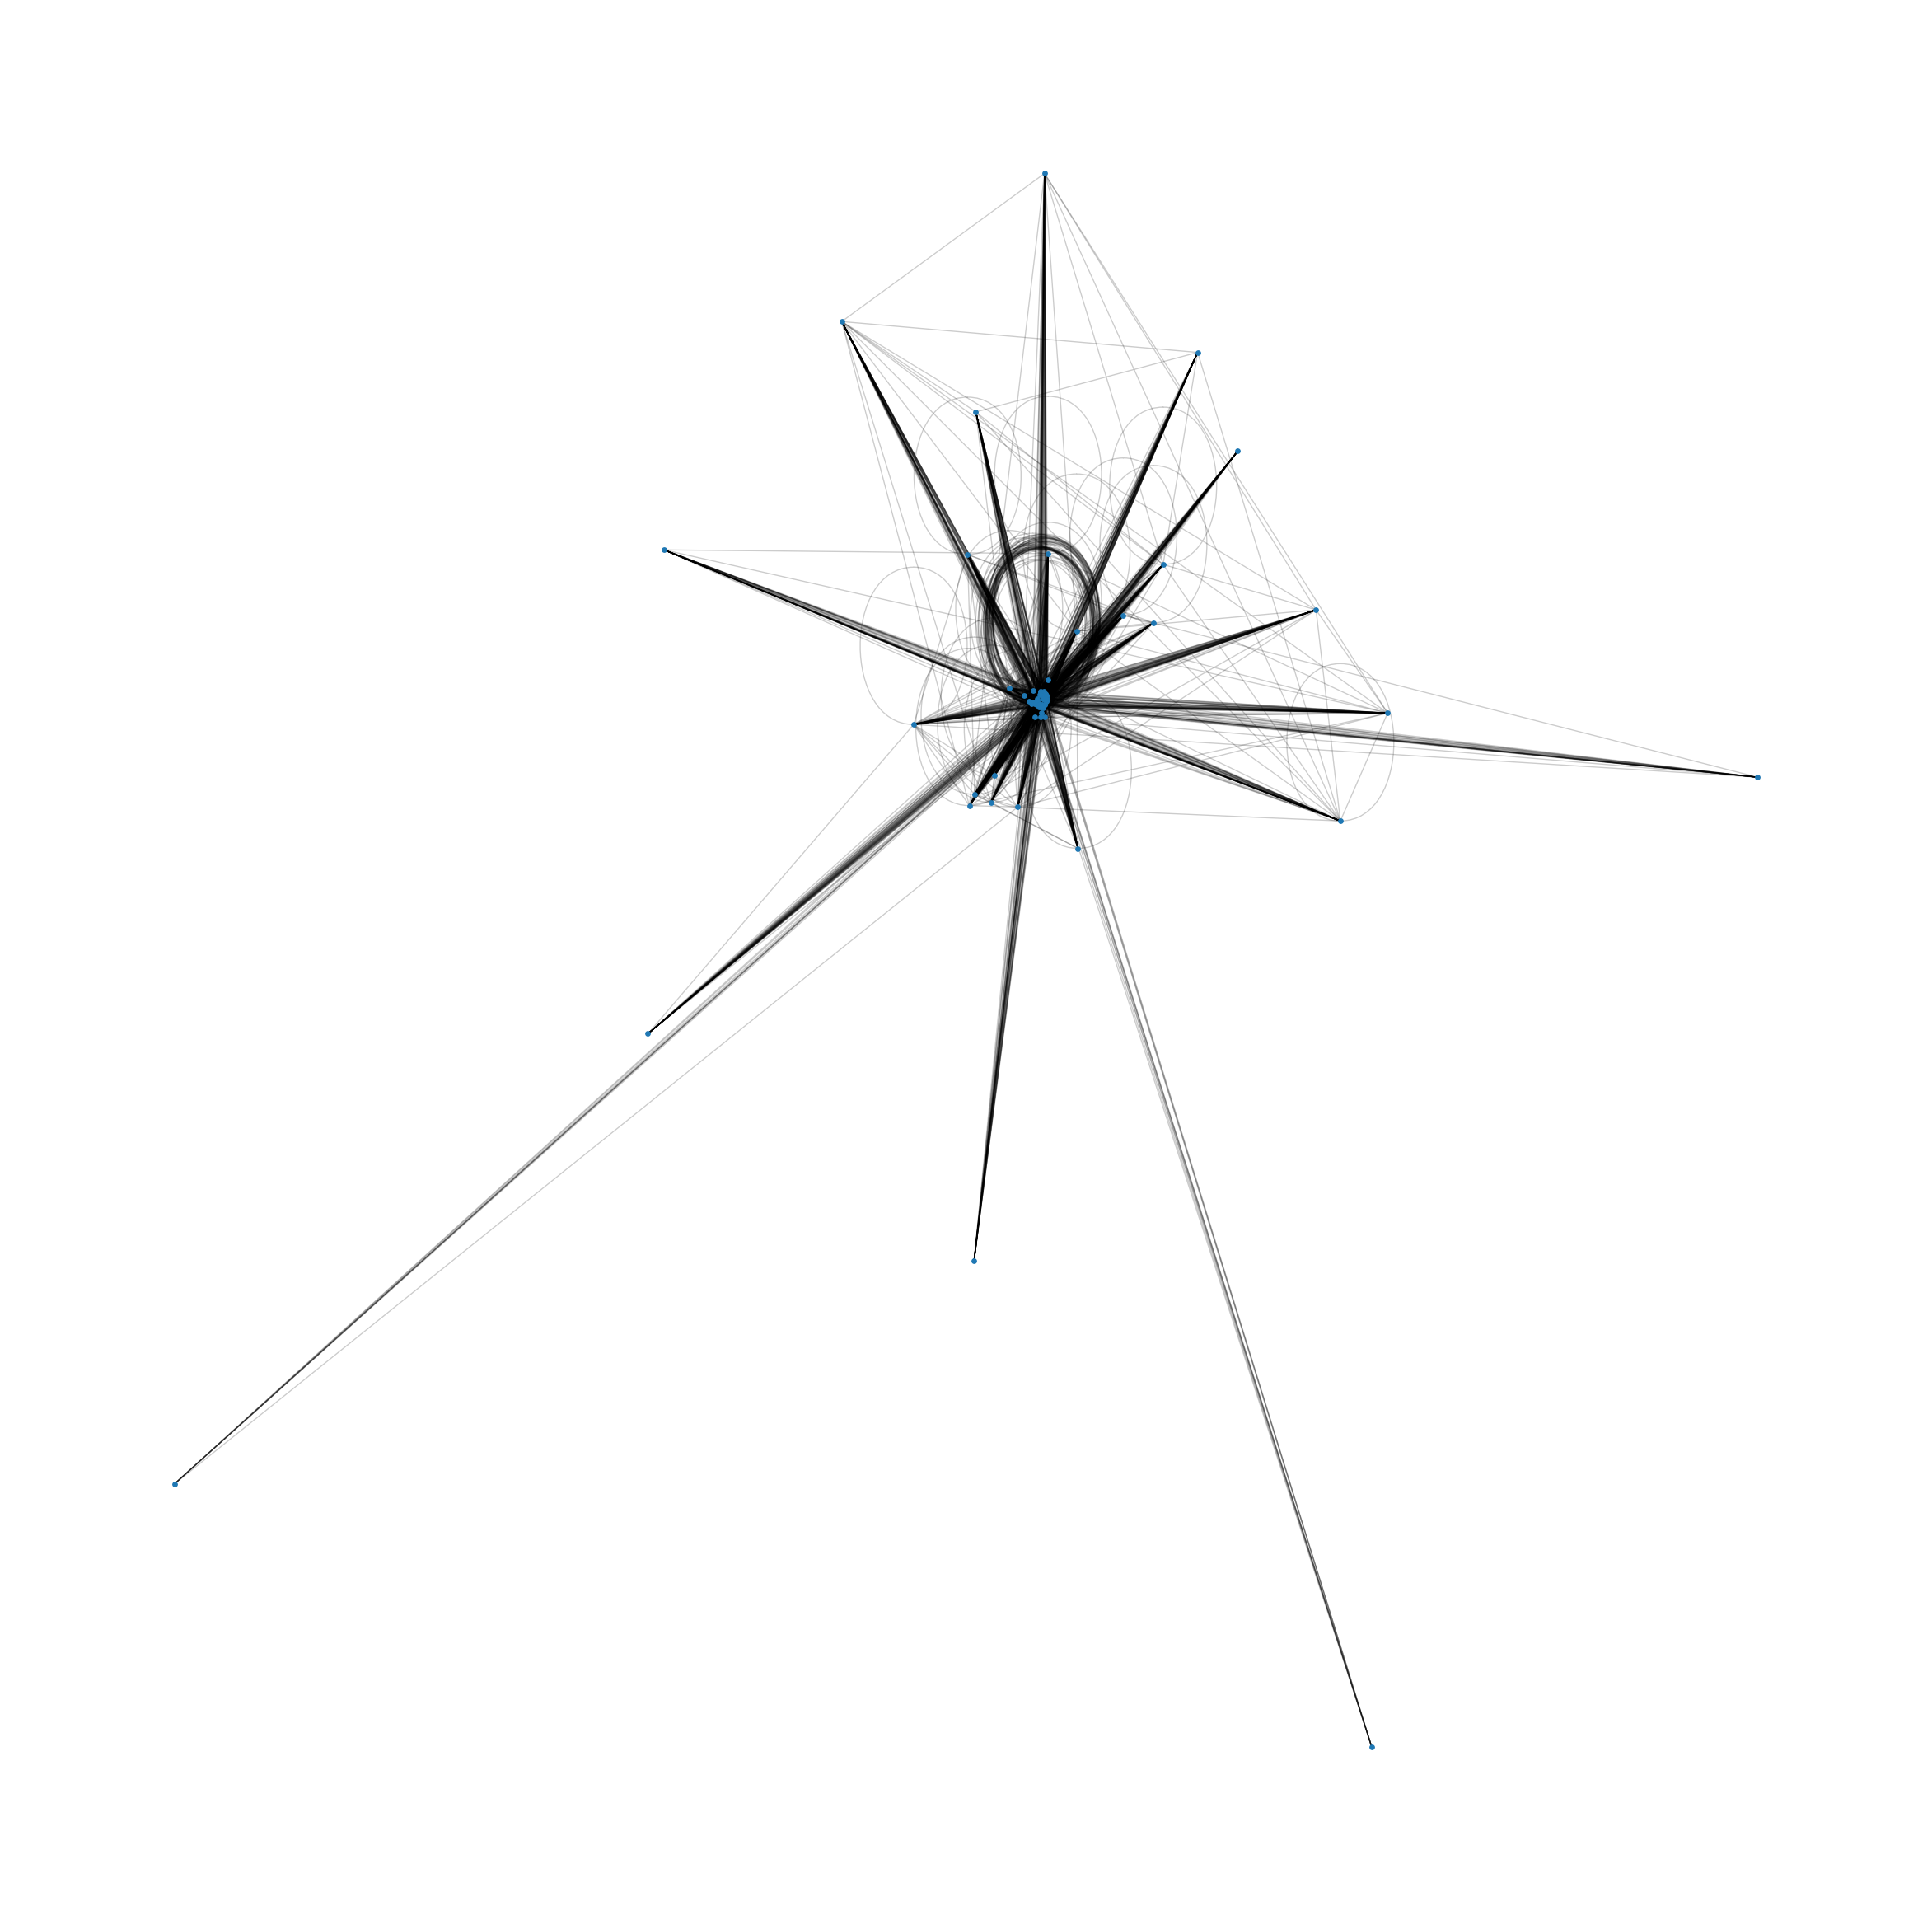

In [27]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1000]
sub_nodes = [n for n, _ in top_nodes]
H = G.subgraph(sub_nodes)


plt.figure(figsize=(30,30))
pos = nx.spring_layout(H, seed=42)

nx.draw_networkx_nodes(H, pos, node_size=15)
nx.draw_networkx_edges(H, pos, alpha=0.2)

plt.axis("off")
plt.show()


Central node: 1441


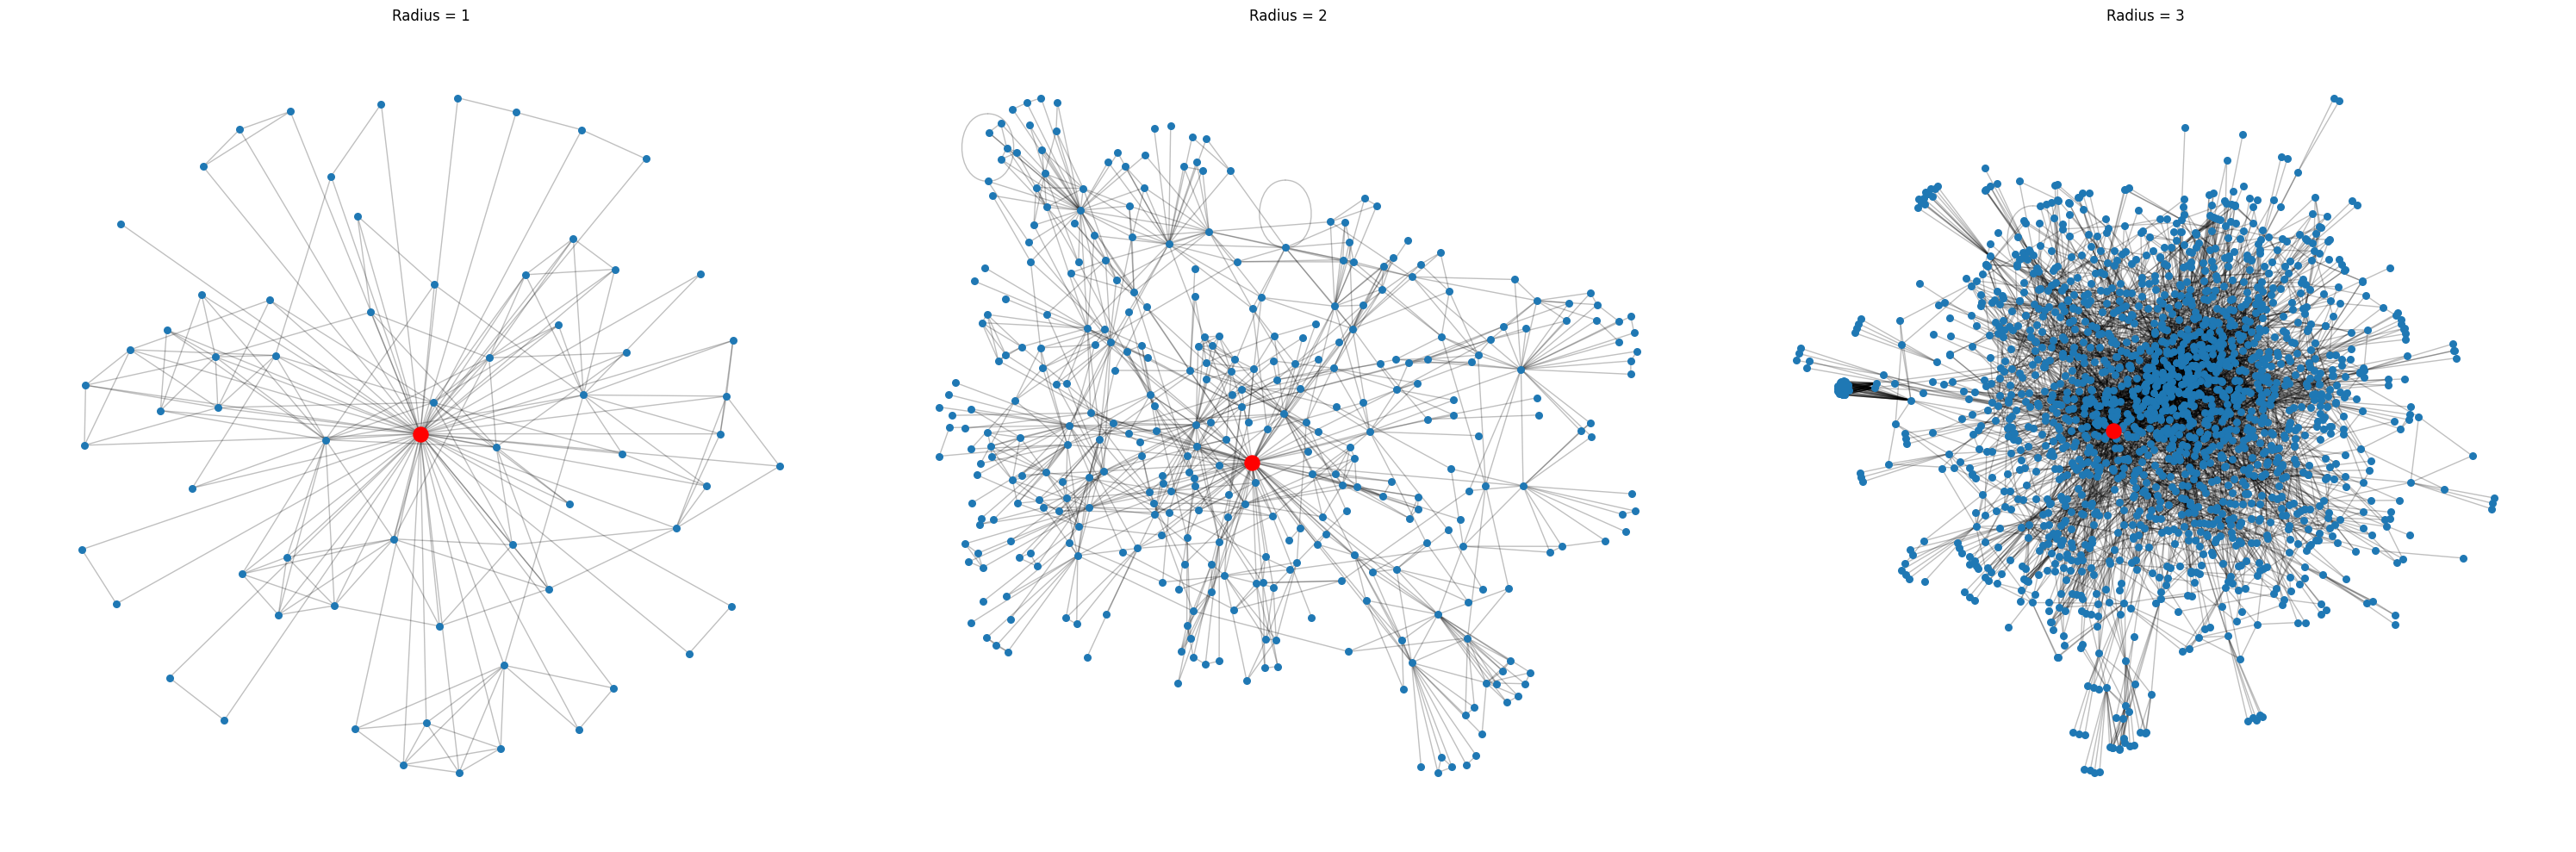

In [37]:
central_node = max(G.degree, key=lambda x: x[1])[0]
print("Central node:", central_node)

# une seule figure avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for ax, radius in zip(axes, [1, 2, 3]):
    H = nx.ego_graph(G, central_node, radius=radius)
    show_graph_from_center(H, central_node, ax, title=f"Radius = {radius}")

plt.tight_layout()
plt.show()


## Centrality Analysis

In a collaboration network like **CA-HepTh**, centrality measures help identify
not just *who collaborates the most*, but also *who connects scientific sub-communities*.

We will use two metrics describe **different roles**:
- Degree → *popularity / collaboration volume*
- Betweenness → *strategic position / connectivity across communities*

### Degree Centrality — *local visibility*
- Measures how many **distinct co-authors** an author has.
- High-degree nodes correspond to **highly active or prolific researchers**.
- Captures **local influence** within the collaboration network.

In [43]:
deg_centrality = nx.degree_centrality(G)

# top 10 authors with highest degree centrality
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_degree

[(1441, 0.006581611988659377),
 (19615, 0.006075334143377886),
 (63113, 0.0059740785743215875),
 (30744, 0.005670311867152693),
 (16164, 0.0054678007290400975),
 (59077, 0.005366545159983799),
 (23420, 0.005366545159983799),
 (48973, 0.005164034021871203),
 (44262, 0.005164034021871203),
 (13648, 0.005062778452814905)]

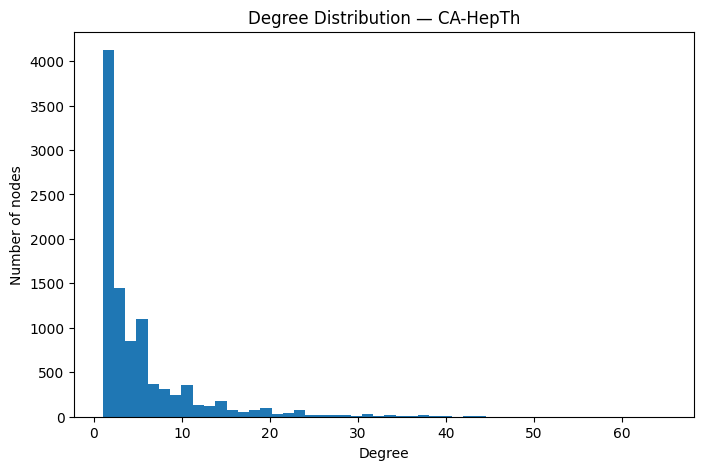

In [44]:
degrees = [d for _, d in G.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution — CA-HepTh")
plt.show()

### Betweenness Centrality — *structural brokerage*
- Measures how often a node lies on **shortest paths** between others.
- High-betweenness nodes act as **bridges between research groups**.
- Identifies **knowledge brokers** connecting subfields of theoretical physics.

In [45]:
bc = nx.betweenness_centrality(G, k=500, seed=42)

# top 10 authors with highest betweenness
top_betweenness = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness


[(44262, 0.02446894898693317),
 (19615, 0.021759279142174313),
 (30744, 0.02163464124977871),
 (43226, 0.01824221940720516),
 (14017, 0.015473962615790086),
 (62227, 0.014537534398902336),
 (37780, 0.0139804949678327),
 (24394, 0.013525827506633864),
 (1441, 0.0127018205618928),
 (33715, 0.012462022313576198)]

## Degree vs Betweenness — Comparison

This scatter shows how **activity (degree)** relates to **structural position (betweenness)**.
- Nodes high in both = **central hubs linking major groups**
- High degree but low betweenness = **local stars** inside dense communities
- Low degree but high betweenness = **rare bridges** connecting otherwise distant areas


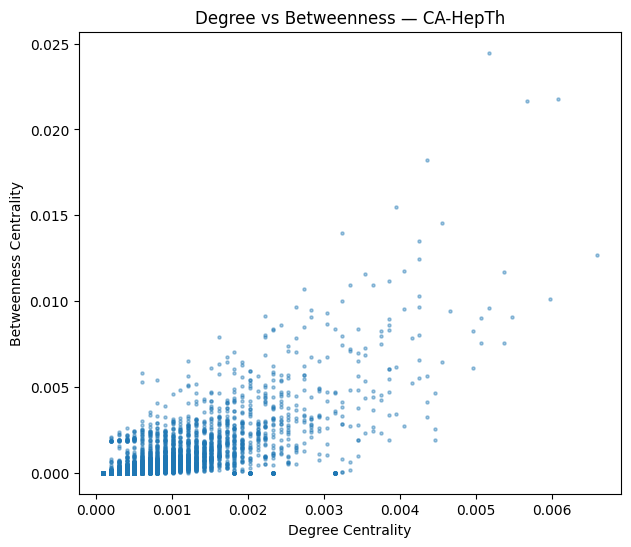

In [46]:
plt.figure(figsize=(7,6))
plt.scatter(
    [deg_centrality[n] for n in G.nodes()],
    [bc[n] for n in G.nodes()],
    s=5, alpha=0.4
)

plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness — CA-HepTh")
plt.show()